## Install the package dependencies before running this notebook

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os, os.path 
import numpy as np
import pickle
from glob import glob
import matplotlib.pyplot as plt
from ArgoDataset import ArgoverseDataset, get_city_trajectories, show_sample_batch

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "validation", "test"]

## Create a Torch.Dataset class for the training dataset

In [2]:
def transform(data):
    # currently 109 input - 109 out
    inp = np.concatenate((data[0], data[1][:-1]))
    out = np.concatenate((data[0][1:], data[1]))

    return (inp, out)

In [3]:
train_dataset  = ArgoverseDataset(city = "all", split = "train")#, transform=transform)
print(train_dataset[0][0])

(163052, 50, 4)
[[ 0.00000000e+00  0.00000000e+00  2.32355047e-04 -2.61898208e-04]
 [ 2.32355047e-04 -2.61898208e-04  2.83106447e-04 -1.72075379e-04]
 [ 5.15461494e-04 -4.33973588e-04  2.89754875e-04 -9.04206324e-05]
 [ 8.05216369e-04 -5.24394220e-04  3.55379236e-04 -1.78365758e-04]
 [ 1.16059560e-03 -7.02759978e-04  4.90603405e-04 -4.49648609e-05]
 [ 1.65119901e-03 -7.47724839e-04  5.09982608e-04  2.79746472e-04]
 [ 2.16118162e-03 -4.67978366e-04  3.29833242e-04 -7.04496475e-04]
 [ 2.49101486e-03 -1.17247484e-03  2.53010107e-04 -1.07292516e-03]
 [ 2.74402497e-03 -2.24540000e-03  4.49352730e-04  5.53389174e-04]
 [ 3.19337770e-03 -1.69201083e-03  5.66244619e-04  2.03115941e-03]
 [ 3.75962231e-03  3.39148584e-04  4.77710266e-04  3.28149800e-03]
 [ 4.23733258e-03  3.62064658e-03  3.44300471e-04  4.21188901e-03]
 [ 4.58163305e-03  7.83253559e-03  2.59591253e-04  4.54597614e-03]
 [ 4.84122431e-03  1.23785117e-02  2.94585910e-04  4.39379794e-03]
 [ 5.13581022e-03  1.67723097e-02  3.37603479e

# Model Constants

In [5]:
batch_sz = 32  # batch size
input_size = 4
hidden_size = 128
output_size = 4
dropout = 0.5
inp_seq_len = 50
num_epochs = 5#15
num_base_epochs = 5
lr = 1e-4
lr_spec = 5e-6

# Baseplate Model

In [5]:
from models import LSTMAttention
from tqdm import tqdm

city_loss_all=dict()
print("Training model baseplate")
# train_dataset  = ArgoverseDataset(city = "all", split = "train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = True)
val_dataset = ArgoverseDataset(city = "all", split = "validation")
val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
val_iter = iter(val_loader)

BEST_PATH = "./models/all_best_attn.pt"
PATH = "./models/baseplate_attn.pt"
best_err = 10000000000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn = LSTMAttention(input_size, hidden_size, output_size, dropout, device).cuda()
criterion = torch.nn.MSELoss()
criterion.to(device)
opt = torch.optim.Adam(rnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.5)

print_every = 1000
val_every = 8
plot_every = 500 / (batch_sz/4)
train_loss = 0
val_loss = 0
train_losses = [-1]
val_losses = [-1]
# fig = plt.figure()

rnn.train()
for epoch in range(num_base_epochs):
    current_loss = 0
    val_iter = iter(val_loader)
    for s_num, (x, y) in tqdm(enumerate(train_loader), \
                              "val_loss: %.3f, best_val: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], best_err, train_losses[-1], epoch)):
        x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)

        opt.zero_grad()
        loss = 0

        y_hat = rnn(x)
        loss = criterion(y_hat, y)

        loss.backward()
        opt.step()

        # Validate every so often
        if s_num % val_every == 0:
            with torch.no_grad():
                rnn.eval()
                vx, vy = next(val_iter)
                vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
                vy_hat = rnn(vx)
                val_loss += criterion(vy_hat, vy)
                del vx
                del vy
                rnn.train()

        # Keep track of average losses
        current_loss += loss.item()
        if s_num != 0 and s_num % plot_every == 0:
            with torch.no_grad():
                train_losses.append(current_loss / plot_every)
                current_loss = 0
                val_losses.append(val_loss / plot_every)
                val_loss = 0
            if val_losses[-1] < best_err:
                torch.save(rnn, BEST_PATH)
                best_err = val_losses[-1]
            scheduler.step(val_losses[-1])
        del x
        del y

city_loss_all["train"] = train_losses
city_loss_all["val"] = val_losses
torch.save(rnn, PATH)

Training model baseplate
(40764, 50, 4)


/opt/conda/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 5096it [12:32,  6.77it/s]
val_loss: 32.748, best_val: 26.831, train_loss: 179.778, epoch #1: 5096it [12:36,  6.73it/s]
val_loss: 7.846, best_val: 7.546, train_loss: 70.106, epoch #2: 5096it [12:35,  6.75it/s]
val_loss: 5.593, best_val: 4.445, train_loss: 48.475, epoch #3: 5096it [12:45,  6.66it/s]
val_loss: 3.339, best_val: 3.285, train_loss: 39.769, epoch #4: 5096it [12:52,  6.60it/s]


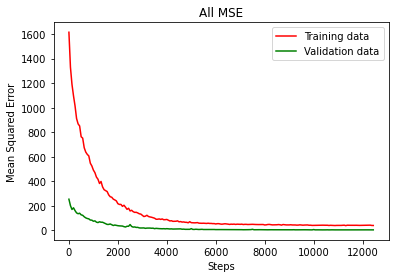

In [6]:
plt.figure()
plt.plot(np.array(range(len(city_loss_all["train"][1:])))*plot_every, city_loss_all["train"][1:],'-r', label="Training data")
plt.plot(np.array(range(len(city_loss_all["val"][1:])))*plot_every, city_loss_all["val"][1:],'-g', label="Validation data")
plt.gca().set_xlabel("Steps")
plt.gca().set_ylabel("Mean Squared Error")
plt.gca().set_title("All MSE")
plt.legend()
plt.show()

(40764, 50, 4)
tensor(9.8439, device='cuda:0')


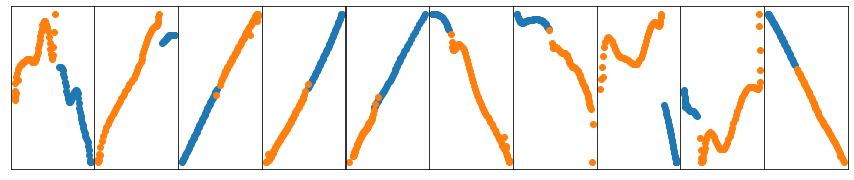

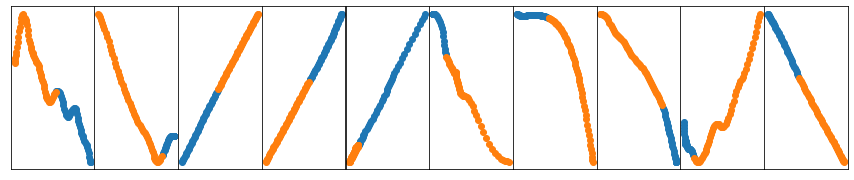

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    rnn = torch.load(f"./models/baseplate_attn.pt").to(device)
    rnn.eval()
    val_dataset = ArgoverseDataset(city = "all", split = "validation")
    val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
    x, y = next(iter(val_loader))
    x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
    y_hat = rnn(x[:, :inp_seq_len])
    loss = torch.nn.MSELoss()
    print(loss(y_hat, y))
    show_sample_batch((x[0:10, :inp_seq_len].cpu(), y_hat.cpu()[0:10]))
    show_sample_batch((x[0:10, :inp_seq_len].cpu(), y[0:10].cpu()))
    plt.show()

# Model Training

In [14]:
from models import LSTM
from tqdm import tqdm

city_loss = dict()

for city in cities:
    city_loss[city]=dict()
    print(f"Training model for {city}")
    train_dataset  = ArgoverseDataset(city = city, split = "train")#, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = True)
    val_dataset = ArgoverseDataset(city = city, split = "validation")
    val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
    val_iter = iter(val_loader)

    BEST_PATH = f"./models/{city}_best_attn.pt"
    PATH = f"./models/{city}_attn.pt"
    best_err = 10000000000

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     rnn = LSTM(input_size, hidden_size, output_size, dropout, device).cuda()
    rnn = torch.load(f"./models/baseplate_attn.pt").to(device)
    criterion = torch.nn.MSELoss()
    criterion.to(device)
    opt = torch.optim.Adam(rnn.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
    # scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.5)

    print_every = 1000
    val_every = 8
    plot_every = 500 / (batch_sz/4)
    train_loss = 0
    val_loss = 0
    train_losses = [-1]
    val_losses = [-1]
    # fig = plt.figure()

    rnn.train()
    for epoch in range(num_epochs):
        current_loss = 0
        val_iter = iter(val_loader)
        for s_num, (x, y) in tqdm(enumerate(train_loader), \
                                  "val_loss: %.3f, best_val: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], best_err, train_losses[-1], epoch)):
            x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)

            opt.zero_grad()
            loss = 0

            y_hat = rnn(x)
            loss = criterion(y_hat, y)

            loss.backward()
            opt.step()

            # Validate every so often
            if s_num % val_every == 0:
                with torch.no_grad():
                    rnn.eval()
                    vx, vy = next(val_iter)
                    vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
                    vy_hat = rnn(vx)
                    val_loss += criterion(vy_hat, vy)
                    del vx
                    del vy
                    rnn.train()

            # Keep track of average losses
            current_loss += loss.item()
            if s_num != 0 and s_num % plot_every == 0:
                with torch.no_grad():
                    train_losses.append(current_loss / plot_every)
                    current_loss = 0
                    val_losses.append(val_loss / plot_every)
                    val_loss = 0
                if val_losses[-1] < best_err:
                    torch.save(rnn, BEST_PATH)
                    best_err = val_losses[-1]
                scheduler.step(val_losses[-1])
            del x
            del y
            
    city_loss[city]["train"] = train_losses
    city_loss[city]["val"] = val_losses
    torch.save(rnn, PATH)

    del rnn
    del criterion
    del scheduler
    del opt
        

Training model for austin
(34432, 50, 4)
(8609, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1076it [02:45,  6.49it/s]
val_loss: 3.074, best_val: 2.935, train_loss: 42.931, epoch #1: 1076it [02:43,  6.58it/s]
val_loss: 3.355, best_val: 2.836, train_loss: 43.819, epoch #2: 1076it [02:42,  6.62it/s]
val_loss: 3.581, best_val: 2.758, train_loss: 42.157, epoch #3: 1076it [02:43,  6.58it/s]
val_loss: 3.045, best_val: 2.673, train_loss: 42.602, epoch #4: 1076it [02:44,  6.55it/s]


Training model for miami
(44023, 50, 4)
(11006, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1376it [03:28,  6.60it/s]
val_loss: 2.392, best_val: 2.389, train_loss: 34.916, epoch #1: 1376it [03:25,  6.71it/s]
val_loss: 2.226, best_val: 2.085, train_loss: 34.385, epoch #2: 1376it [03:26,  6.66it/s]
val_loss: 2.145, best_val: 2.085, train_loss: 32.691, epoch #3: 1376it [03:34,  6.41it/s]
val_loss: 2.141, best_val: 2.085, train_loss: 32.784, epoch #4: 1376it [03:34,  6.43it/s]


Training model for pittsburgh
(34835, 50, 4)
(8709, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1089it [02:48,  6.47it/s]
val_loss: 2.805, best_val: 2.709, train_loss: 36.295, epoch #1: 1089it [02:46,  6.52it/s]
val_loss: 2.769, best_val: 2.373, train_loss: 36.753, epoch #2: 1089it [02:47,  6.51it/s]
val_loss: 2.338, best_val: 2.338, train_loss: 33.113, epoch #3: 1089it [02:43,  6.66it/s]
val_loss: 2.376, best_val: 2.246, train_loss: 35.309, epoch #4: 1089it [02:43,  6.66it/s]


Training model for dearborn
(19572, 50, 4)
(4893, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 612it [01:28,  6.90it/s]
val_loss: 4.251, best_val: 3.751, train_loss: 59.825, epoch #1: 612it [01:24,  7.25it/s]
val_loss: 3.886, best_val: 3.630, train_loss: 59.325, epoch #2: 612it [01:21,  7.48it/s]
val_loss: 3.924, best_val: 3.445, train_loss: 57.285, epoch #3: 612it [01:22,  7.38it/s]
val_loss: 3.522, best_val: 3.225, train_loss: 56.720, epoch #4: 612it [01:22,  7.41it/s]


Training model for washington-dc
(20595, 50, 4)
(5149, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 644it [01:27,  7.37it/s]
val_loss: 3.330, best_val: 2.844, train_loss: 41.140, epoch #1: 644it [01:29,  7.20it/s]
val_loss: 2.957, best_val: 2.844, train_loss: 41.586, epoch #2: 644it [01:32,  6.97it/s]
val_loss: 2.939, best_val: 2.844, train_loss: 37.869, epoch #3: 644it [01:30,  7.11it/s]
val_loss: 2.753, best_val: 2.753, train_loss: 38.160, epoch #4: 644it [01:31,  7.03it/s]


Training model for palo-alto
(9594, 50, 4)
(2399, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 300it [00:42,  7.06it/s]
val_loss: 4.778, best_val: 4.778, train_loss: 63.384, epoch #1: 300it [00:42,  7.00it/s]
val_loss: 4.476, best_val: 4.476, train_loss: 61.025, epoch #2: 300it [00:41,  7.14it/s]
val_loss: 4.339, best_val: 4.339, train_loss: 58.364, epoch #3: 300it [00:42,  7.05it/s]
val_loss: 4.238, best_val: 4.238, train_loss: 56.229, epoch #4: 300it [00:41,  7.30it/s]


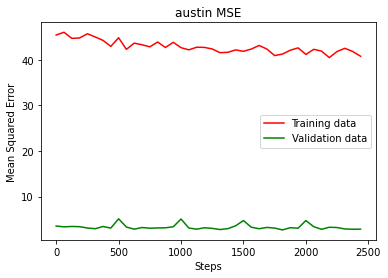

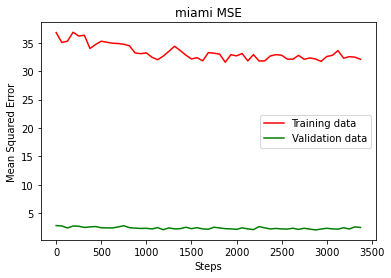

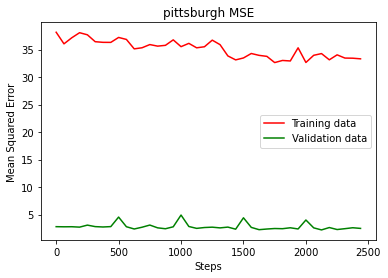

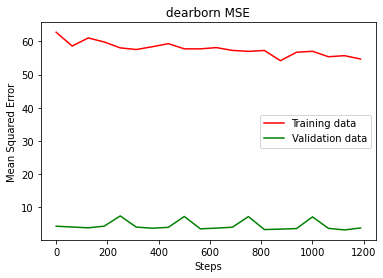

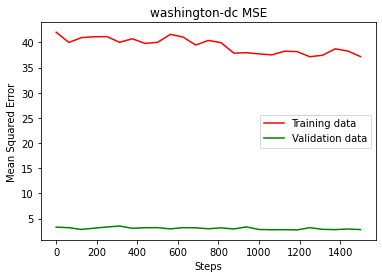

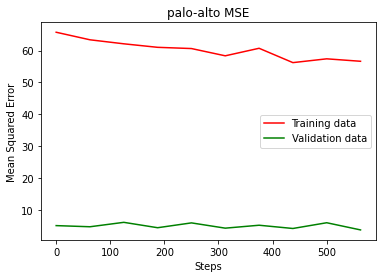

In [15]:
for i, city in enumerate(city_loss):
    plt.figure(i)
    plt.plot(np.array(range(len(city_loss[city]["train"][1:])))*plot_every, city_loss[city]["train"][1:],'-r', label="Training data")
    plt.plot(np.array(range(len(city_loss[city]["val"][1:])))*plot_every, city_loss[city]["val"][1:],'-g', label="Validation data")
    plt.gca().set_xlabel("Steps")
    plt.gca().set_ylabel("Mean Squared Error")
    plt.gca().set_title(f"{city} MSE")
    plt.legend()
    plt.show()

(8609, 50, 4)
tensor(51.2591, device='cuda:0')


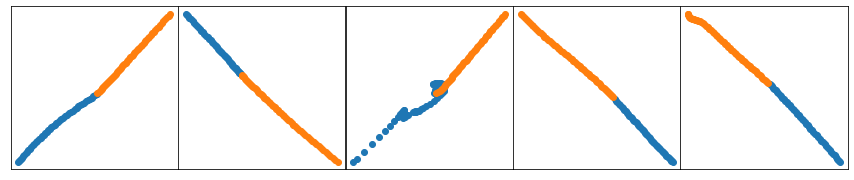

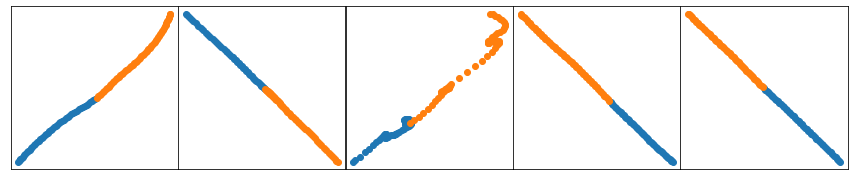

(11006, 50, 4)
tensor(41.0838, device='cuda:0')


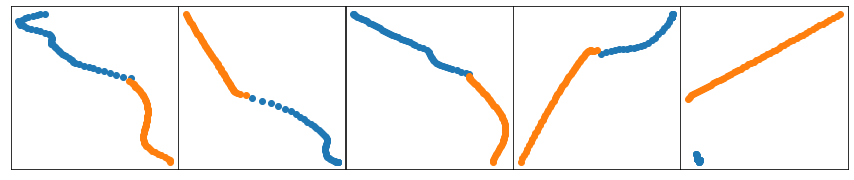

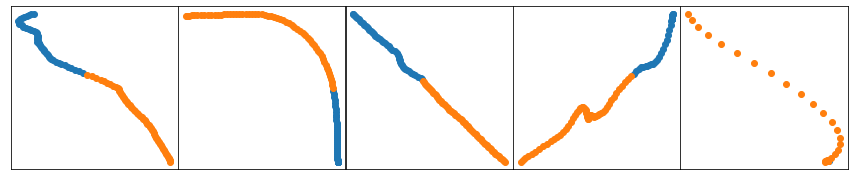

(8709, 50, 4)
tensor(29.3576, device='cuda:0')


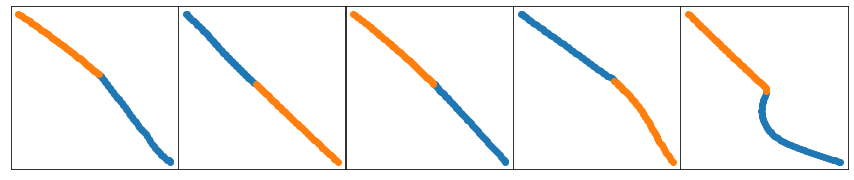

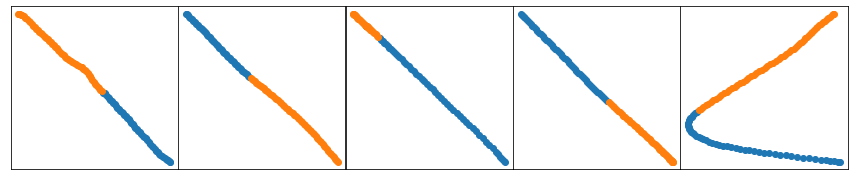

(4893, 50, 4)
tensor(49.6435, device='cuda:0')


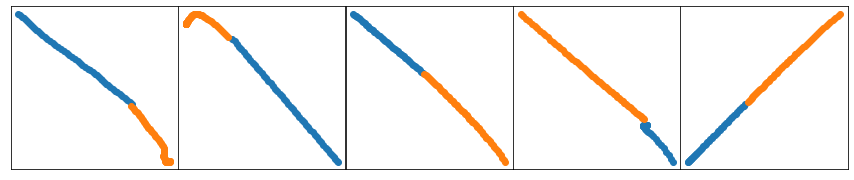

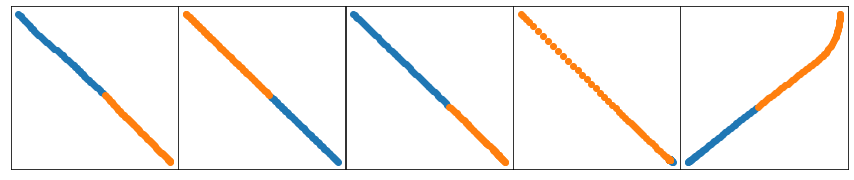

(5149, 50, 4)
tensor(35.2870, device='cuda:0')


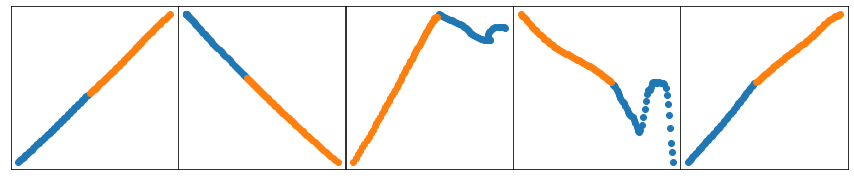

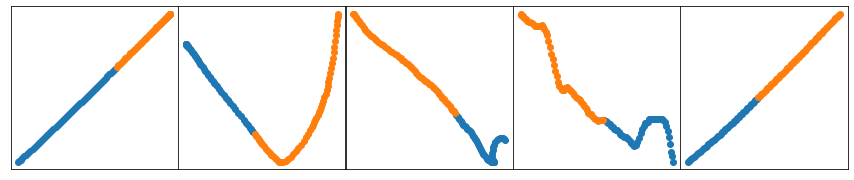

(2399, 50, 4)
tensor(56.7533, device='cuda:0')


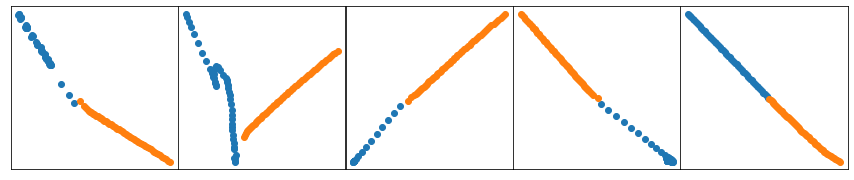

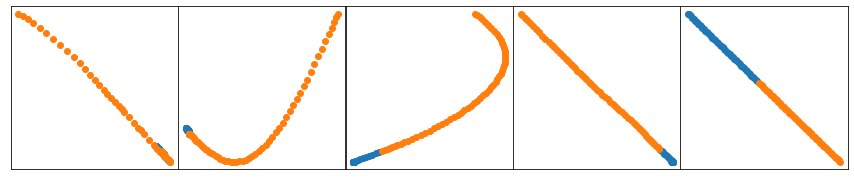

In [16]:
with torch.no_grad():
    for city in city_loss:
        rnn = torch.load(f"./models/{city}_best.pt").to(device)
        rnn.eval()
        val_dataset = ArgoverseDataset(city = city, split = "validation")
        val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
        x, y = next(iter(val_loader))
        x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
        y_hat = rnn(x[:, :inp_seq_len])
        loss = torch.nn.MSELoss()
        print(loss(y_hat, y))
        show_sample_batch((x[0:5, :inp_seq_len].cpu(), y_hat.cpu()[0:5]))
#         del rnn
#         rnn = torch.load(f"./models/{city}.pt").to(device)
#         rnn.eval()
#         y_hat = rnn(x[:, :inp_seq_len])
#         loss = torch.nn.MSELoss()
#         print(loss(y_hat, y))
#         show_sample_batch((x[0:10, :inp_seq_len].cpu(), y_hat.cpu()[0:10]))
        show_sample_batch((x[0:5, :inp_seq_len].cpu(), y[0:5, :].cpu()))
        plt.show()
        del rnn

# Examining the submission format

In [33]:
import pandas as pd

In [7]:
sample_sub = pd.read_csv('./argo2/sample_submission.csv')
sample_sub.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
%load_ext autoreload
%autoreload 2

In [9]:
from prediction import get_traj_pred

ModuleNotFoundError: No module named 'prediction'

Processing city austin
(6325, 50, 2)
(6325, 50, 4)
(6325, 60, 4)
(6325, 60, 2)
(6325, 120)
[  27.86433403 -580.02025069]
Processing city miami
(7971, 50, 2)
(7971, 50, 4)
(7971, 60, 4)
(7971, 60, 2)
(7971, 120)
[5928.7169812  1469.72844621]
Processing city pittsburgh
(6361, 50, 2)
(6361, 50, 4)
(6361, 60, 4)
(6361, 60, 2)
(6361, 120)
[4059.06160213  207.185043  ]
Processing city dearborn
(3671, 50, 2)
(3671, 50, 4)
(3671, 60, 4)
(3671, 60, 2)
(3671, 120)
[9384.91646135 3282.67523702]
Processing city washington-dc
(3829, 50, 2)
(3829, 50, 4)
(3829, 60, 4)
(3829, 60, 2)
(3829, 120)
[1540.78922806  720.24440437]
Processing city palo-alto
(1686, 50, 2)
(1686, 50, 4)
(1686, 60, 4)
(1686, 60, 2)
(1686, 120)
[ 566.7580094  1909.85977658]


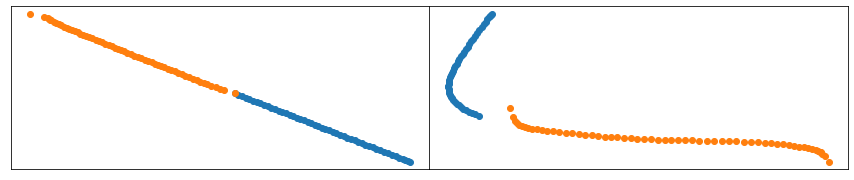

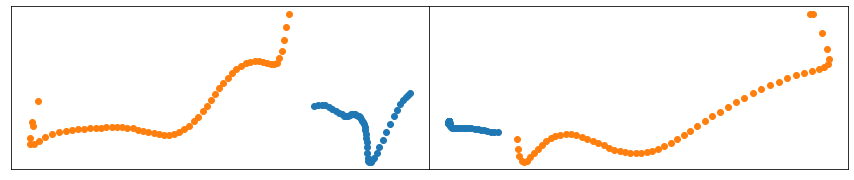

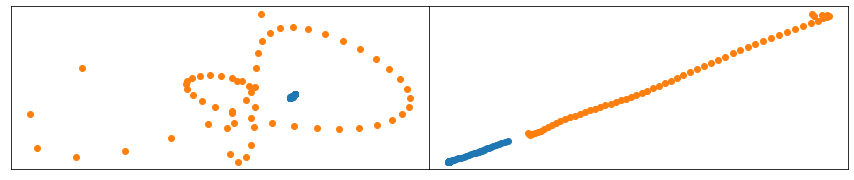

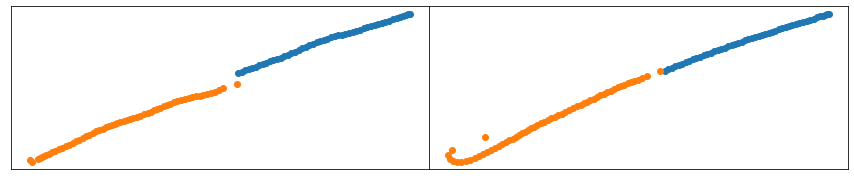

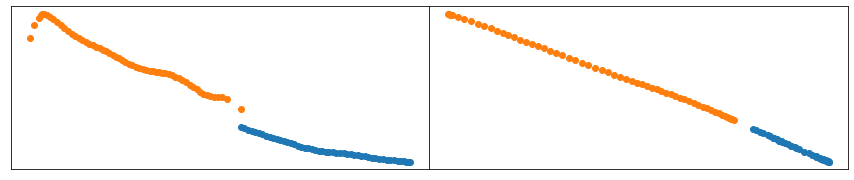

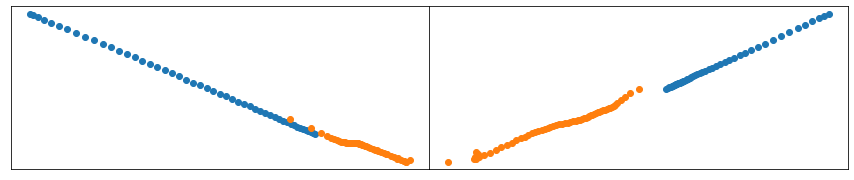

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])
# rnn = torch.load("./models/all_best_attn.pt").to(device)
for city_name in cities:

    print("Processing city", city_name)
    rnn = torch.load(f"./models/{city_name}_best_attn.pt").to(device)
    rnn.eval()
    test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    print(test_traj_in.shape)
#   normal_traj = np.zeros(shape=test_traj_in.shape)
    normal_traj  = ArgoverseDataset(city = city_name, split = "test").inputs

    starts = test_traj_in[:,0]

    traj = torch.from_numpy(normal_traj).to(torch.float32).to(device)
    test_pred_arr = rnn(traj).cpu().detach().numpy()
    print(test_pred_arr.shape)
    
    test_pred_arr = test_pred_arr[:,:,:2]
    print(test_pred_arr.shape)
    
    for i in range(test_traj_in.shape[0]):
        test_pred_arr[i]+=starts[i]
    
 
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
    print(test_pred_arr_reshaped.shape)

    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]
    print(test_traj_in[0][0])
    show_sample_batch((torch.tensor(test_traj_in[0:2]), torch.tensor(test_pred_arr[0:2])))
    
    del rnn
# del rnn

In [18]:
import pandas as pd
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
sub_df.to_csv('./submissions/attn_spec.csv', index=None)